## Setup


In [1]:
# Get the dependencies
!pip install -Uq git+https://github.com/IDEA-Research/GroundingDINO.git >> /dev/null
!pip install -Uq torch torchvision torchaudio torchtext >> /dev/null
!pip install -Uq tensorflow >> /dev/null
!pip install -Uq jax >> /dev/null
!pip install -Uq keras-nlp >> /dev/null
!pip install -Uq keras-cv >> /dev/null
!pip install -Uq keras >> /dev/null

# Some care is required to install Keras 3. This is a temporary situation.
# See installation notes at the end of this notebook for details.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [3]:
#@title Backend selection and display utilities [run me]
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def big_print(a,b):
  html = '<div style="font-size: 18pt; font-family: monospace">{}{}</div>'.format(a, b)
  display(HTML(html))
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

backend = 'tensorflow' # @param ["jax", "tensorflow", "torch"]

In [4]:
import math, os, random
os.environ['KERAS_BACKEND'] = backend

import keras
import keras_cv

backend = keras.config.backend()
big_print('\u2B50 ', 'Keras version '+keras.version())
big_print('\u2B50 ', 'Running on '+backend.upper())

<hr/>

# <img src="https://keras.io/img/k-logo.png" height="80pt" align="center"/> Keras 3: Load and run a Keras-CV model - Stable Diffusion

The Stable diffusion model generates images from text prompts.

In [5]:
stable_diffusion = keras_cv.models.StableDiffusion()
if backend=="torch":
  stable_diffusion.jit_compile = False # work in progress on PyTorch...

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 216ms/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


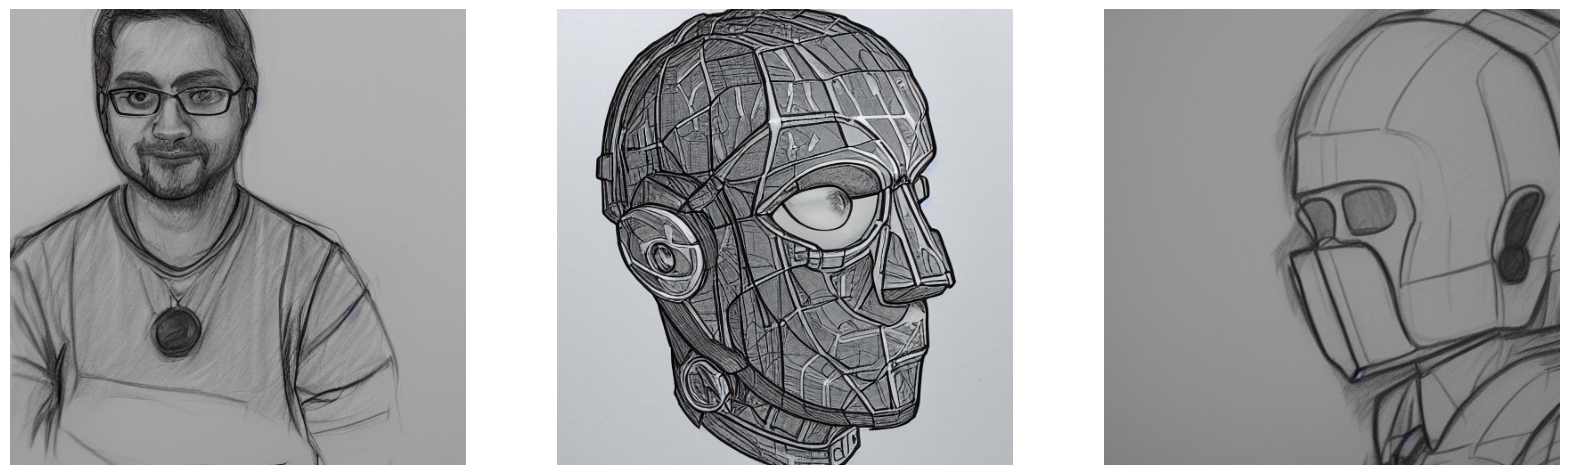

In [6]:
prompt = "A refined pencil sketch of a {} machine learning developer.".format(backend.upper())
images = stable_diffusion.text_to_image(prompt, batch_size=3)

big_print("\U0001F4DD	 ",prompt)
plot_images(images)

<hr/>

# <img src="https://keras.io/img/k-logo.png" height="80pt" align="center"/> Keras 3: Text prompted segment anything model



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras import ops

from groundingdino.util.inference import Model as GroundingDinoModel

In [8]:
# Get the Grounding Dino model weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py

## Helper functions

In [9]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(
        image[None, ...], preprocess_shape
    )[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV now rescales the images and normalizes them.
        # Just unnormalize such that when KerasCV normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

## Download weights for the grounding dino model

In [10]:
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDinoModel(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Sample input image

1236492/1236492 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


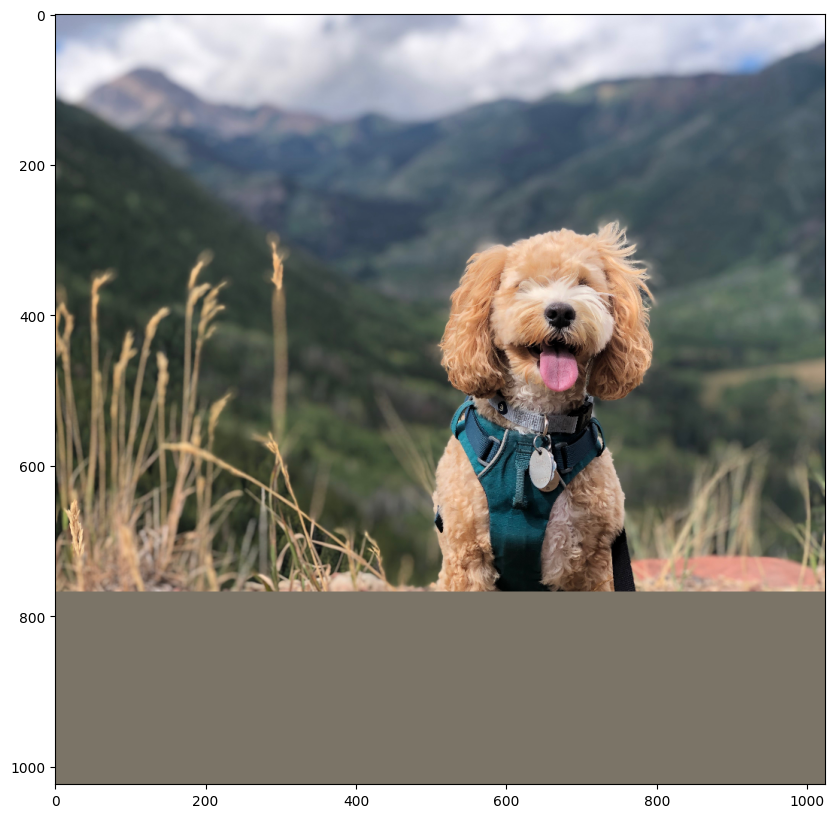

In [11]:
filepath = keras.utils.get_file(origin="https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg")
image = keras.utils.load_img(filepath)
image = inference_resizing(image)

plt.figure(figsize=(10,10))
plt.imshow(image / 255.)
plt.axis('on')
plt.show()

# Lets try text prompted segment anything

In [12]:
# Let's predict the bounding box for the harness of the dog
boxes = grounding_dino.predict_with_caption(
    np.array(image, dtype=np.uint8),
    "harness"
)
boxes = np.array(boxes[0].xyxy[0])

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [17]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")
model.compile(
    jit_compile=False,
    run_eagerly=True
)
outputs = model.predict({
    "images": image[np.newaxis, ...],
    "boxes": boxes.reshape(1, 1, 2, 2),
})

2564774344/2564774344 ━━━━━━━━━━━━━━━━━━━━ 259s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


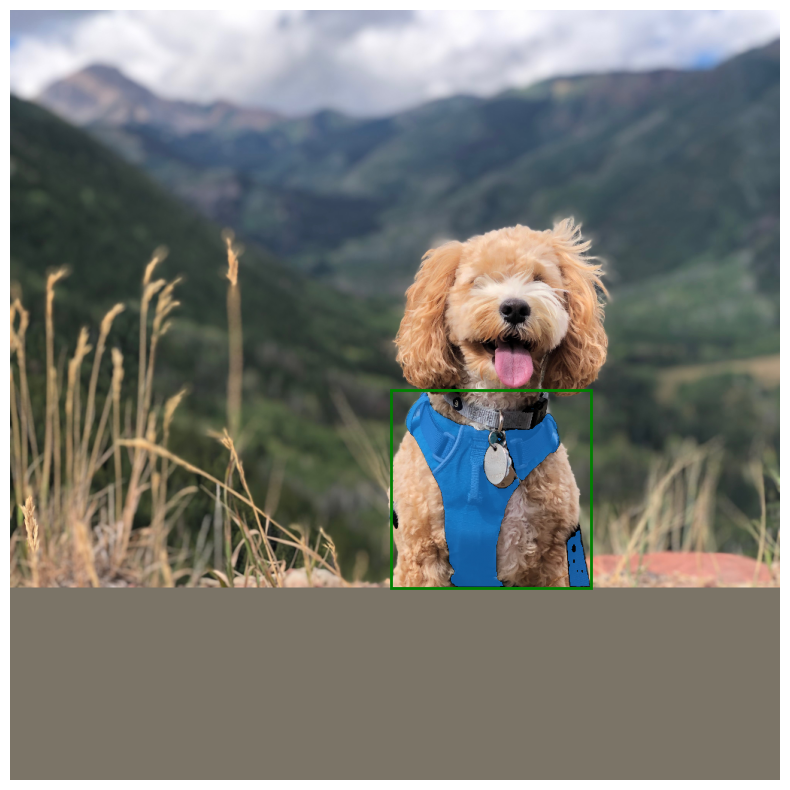

In [18]:
mask = inference_resizing(
    outputs["masks"][0][0][..., None], pad=False
)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.)
show_mask(mask, plt.gca())
show_box(boxes, plt.gca())
plt.axis('off')
plt.show()